In [1]:
#the following packages are required for this project.
#to install them, uncomment the next lines
#!pip install wordcloud
#!pip install keras
#!pip install tensorflow
#!pip install imblearn
#!pip install scikit-multilearn
#!pip install transformers
#!pip install datasets

In [2]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
%cd /drive/My Drive/Colab Notebooks/ToxicComment

/drive/My Drive/Colab Notebooks/ToxicComment


# 1. Preparing data

Unzipping and storing files in "data_raw" directory

In [4]:
import glob, os
import zipfile
from collections import Counter

for file in glob.glob("*.zip"):    
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall("data_raw")

Reading files for further exploration

In [5]:
import pandas as pd
import numpy as np

train_data = 'data_raw/train.csv'
train_data = pd.read_csv(train_data)
test_comments = 'data_raw/test.csv'
test_comments = pd.read_csv(test_comments)
test_labels = 'data_raw/test_labels.csv'
test_labels = pd.read_csv(test_labels)
#glove.6B.100d.txt can be downloaded from here: https://www.kaggle.com/danielwillgeorge/glove6b100dtxt
#embedding_file = 'data_raw/glove.6B.100d.txt'

# 2. Exploratory data analysis

## 2.1 Overview of training and test sets

In [6]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
print("The total number of comments in training set is", train_data.shape[0])

The total number of comments in training set is 159571


In [8]:
test_comments.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [9]:
print("The total number of comments in test set is", test_comments.shape[0])

The total number of comments in test set is 153164


In [10]:
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [11]:
print("The total number of labels in test set is", test_labels.shape[0])

The total number of labels in test set is 153164


## 2.2 Diagnostics

Checking for duplicates in comments

In [12]:
print("Number of duplicates in training set:", train_data[train_data['comment_text'].duplicated(keep=False)].shape[0])

Number of duplicates in training set: 0


In [13]:
print("Number of duplicates in test set:", test_comments[test_comments['comment_text'].duplicated(keep=False)].shape[0])

Number of duplicates in test set: 0


Cheking for null values in training set

In [14]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Cheking for null values in test set

In [15]:
test_comments.isnull().sum()

id              0
comment_text    0
dtype: int64

## 2.3 Exploring training set

Adding a label for neutral comment

In [16]:
outputs_train = list(train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']])
neutral = train_data[outputs_train].sum(axis=1)

train_data['neutral'] = (neutral == 0).astype("int")
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


### 2.3.1 Visualizing comments per label in training set

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


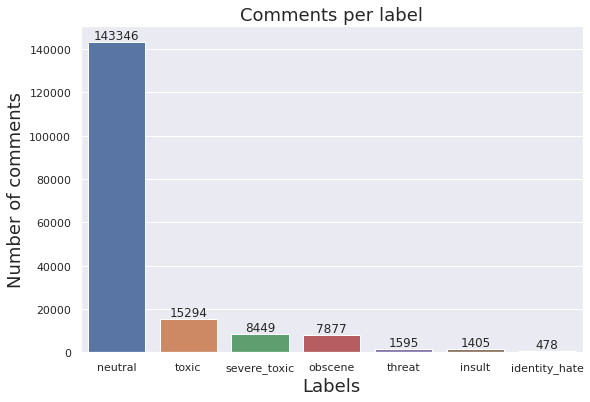

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

outputs_train = list(train_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']])
sns.set(font_scale = 1)
plt.figure(figsize=(9,6))
ax = sns.barplot(outputs_train, 
                 sorted(train_data[['neutral','toxic','severe_toxic','obscene',
                               'threat','insult','identity_hate']].sum().values, reverse=True))
plt.title("Comments per label", fontsize=18)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = sorted(train_data[['neutral','toxic','severe_toxic','obscene',
                       'threat','insult','identity_hate']].sum().values, reverse=True)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### 2.3.2 Visualizing comments per number of labels in training set

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


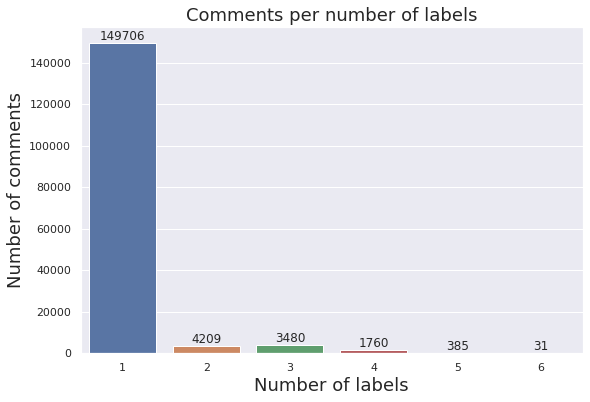

In [18]:
rowSums = train_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
sns.set(font_scale = 1)
plt.figure(figsize=(9,6))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments per number of labels", fontsize=18)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

# 3. Feature engineering

## 3.1 Preparing test data

In [19]:
test_data = pd.merge(test_comments, test_labels, on=['id'])
test_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1


Adding a label for neutral comment

In [20]:
outputs_test = list(test_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']])
neutral = test_data[outputs_test].sum(axis=1)

test_data['neutral'] = (neutral == 0).astype("int")
outputs_test = list(test_data[['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']])
test_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1,0
...,...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",-1,-1,-1,-1,-1,-1,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,-1,-1,-1,-1,-1,-1,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",-1,-1,-1,-1,-1,-1,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",-1,-1,-1,-1,-1,-1,0


Drop values not used for scoring (-1)

In [21]:
for cols in test_data[outputs_test]:
    test_data = test_data[test_data[cols] >= 0]
    test_data = test_data.reset_index(drop=True)
    
test_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,1
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,1
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,1
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,1
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0,1
63974,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0,1
63975,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0,1
63976,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0,0


## 3.2 Processing the training and test data

### 3.2.1 Cleaning comments

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

def comment_to_words(comment):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = str(comment)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    
    return words

Cache processing comments since it can take a long time

In [23]:
#from https://github.com/udacity/sagemaker-deployment/blob/master/Project/SageMaker%20Project.ipynb
import pickle

cache_dir = "cache"  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_comments(data_train, data_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [comment_to_words(comment) for comment in data_train]
        words_test = [comment_to_words(comment) for comment in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test = (cache_data['words_train'], cache_data['words_test'])
    
    return words_train, words_test

In [24]:
# Preprocess data
words_train, words_test = preprocess_comments(train_data['comment_text'], test_data['comment_text'])

Read preprocessed data from cache file: preprocessed_data.pkl


In [25]:
train_data['comment_words'] = [" ".join(i) for i in words_train]
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_words
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,aww matches background colour seemingly stuck ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,make real suggestions improvement wondered sec...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,sir hero chance remember page
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1,second time asking view completely contradicts...
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1,ashamed horrible thing put talk page 128 61 19 93
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1,spitzer umm theres actual article prostitution...
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1,looks like actually put speedy first version d...


In [26]:
train_data['comment_words'][0]

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired 89 205 38 27'

In [27]:
test_data['comment_words'] = [" ".join(i) for i in words_test]
test_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_words
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,1,thank understanding think highly would revert ...
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,1,dear god site horrible
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,1,somebody invariably try add religion really me...
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,1,says right type type institution needed case t...
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,1,adding new product list make sure relevant add...
...,...,...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0,1,jerome see never got around surprised looked e...
63974,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0,1,lucky bastard http wikimediafoundation org wik...
63975,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0,1,shame want speak gays romanians
63976,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0,0,mel gibson nazi bitch makes shitty movies much...


In [28]:
test_data['comment_words'][0]

'thank understanding think highly would revert without discussion'

### 3.2.2 Visualizing word clouds for training set

In [29]:
from wordcloud import WordCloud

def display_cloud(label):
    words = ' '.join(train_data.loc[train_data[label] == 1, 'comment_words'].to_list())
    wordcloud=WordCloud(max_words=200, width=800,height=400,background_color='black',collocations=False).generate(words)
    plt.figure(figsize=(18,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for {}".format(label), fontsize=18)
    plt.show()

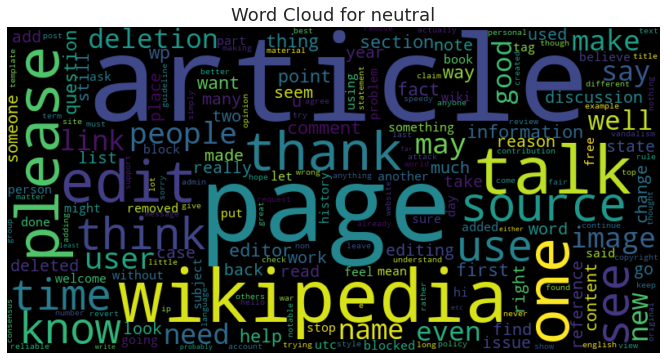

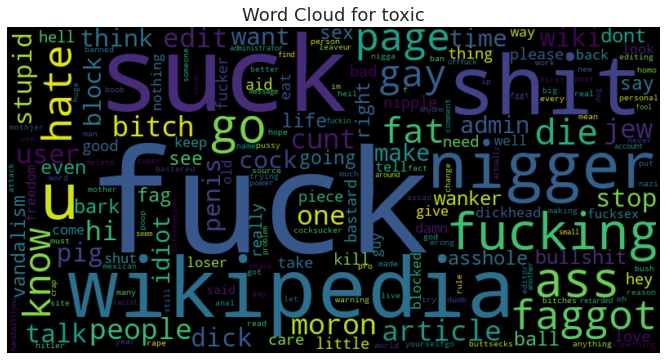

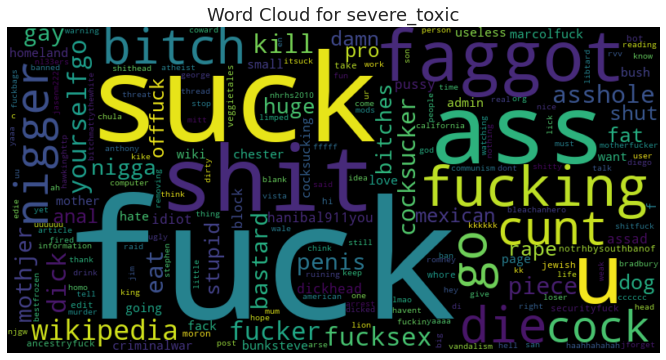

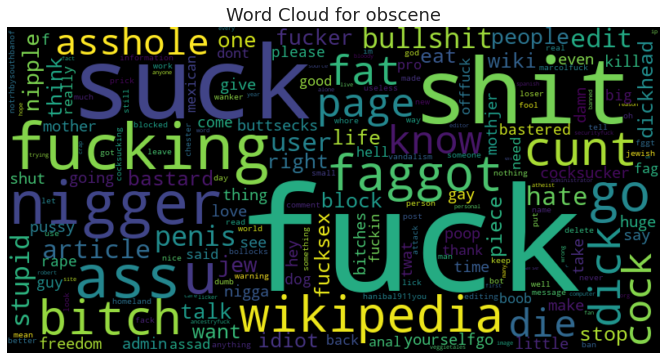

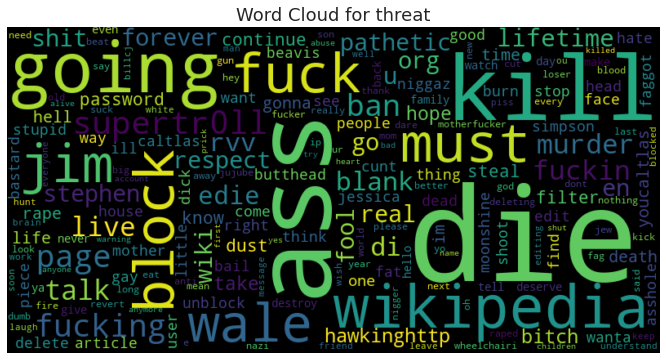

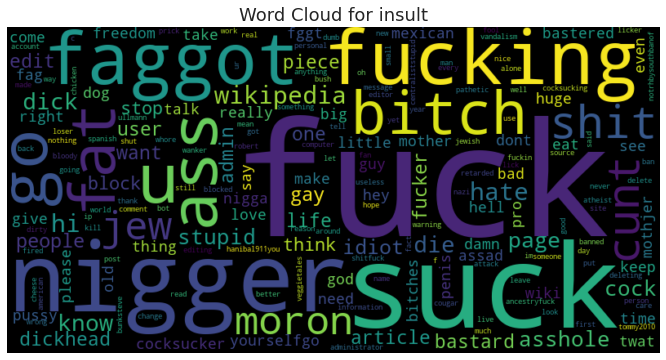

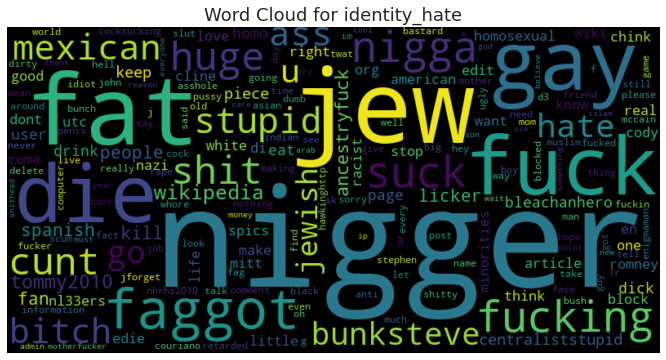

In [30]:
for label in ['neutral','toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    display_cloud(label)

# 4. Modeling

## 4.1 Multilabel Naive Bayes

### 4.1.1 Converting text for modeling, creating training and test data

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=1000)

In [32]:
X_train = word_vectorizer.fit_transform(train_data["comment_words"]).toarray()
X_test = word_vectorizer.fit_transform(test_data["comment_words"]).toarray()

print("Training input shape is:", X_train.shape)
print("Testing input shape is:", X_test.shape)

Training input shape is: (159571, 1000)
Testing input shape is: (63978, 1000)


In [33]:
y_train = train_data[outputs_train]
y_test = test_data[outputs_test]

print("Training output shape is:", y_train.shape)
print("Testing output shape is:", y_test.shape)

Training output shape is: (159571, 7)
Testing output shape is: (63978, 7)


In [34]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, multilabel_confusion_matrix, classification_report

### 4.1.2 Training

In [35]:
nb_clf = BinaryRelevance(MultinomialNB(), require_dense = [False, True]) #X values in sparse format but not the y values
nb_clf.fit(X_train, y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[False, True])

### 4.1.3 Testing

In [36]:
y_pred = nb_clf.predict(X_test).todense()

In [44]:
def metrics(y_test,y_pred):
    f1 = f1_score(y_test,y_pred, average='micro')
    roc_auc = roc_auc_score(y_test,y_pred, average='micro')
    accuracy = accuracy_score(y_test,y_pred)
    conf_m = multilabel_confusion_matrix(y_test,y_pred)

    print("F1 score:", f1)
    print("ROC score:", roc_auc)
    print("Accuracy:", accuracy)

    print("\nConfusion matrix:\n",conf_m)

In [45]:
metrics(y_test,y_pred)

F1 score: 0.8384790094512418
ROC score: 0.8867285065492349
Accuracy: 0.8909781487386289

Confusion matrix:
 [[[  268  5975]
  [  791 56944]]

 [[57276   612]
  [ 5886   204]]

 [[63610     1]
  [  367     0]]

 [[60027   260]
  [ 3651    40]]

 [[63767     0]
  [  211     0]]

 [[60369   182]
  [ 3393    34]]

 [[63261     5]
  [  712     0]]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


## 4.2 BERT

In [46]:
from sklearn.model_selection import train_test_split

# split into training & testing
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_data["comment_words"], 
                                                                        train_data[outputs_train], 
                                                                        test_size=0.2)

In [47]:
train = pd.concat([train_texts,train_labels],axis=1)
valid = pd.concat([valid_texts,valid_labels],axis=1)

In [48]:
from datasets import Dataset

In [49]:
dataset_train = Dataset.from_pandas(train)
dataset_valid = Dataset.from_pandas(valid)

In [50]:
dataset_train[0]

{'__index_level_0__': 134942,
 'comment_words': 'thank experimenting page back future wikipedia test worked reverted removed please use sandbox tests want take look welcome page would like learn contributing encyclopedia slgr ndson messages contribs',
 'identity_hate': 0,
 'insult': 0,
 'neutral': 1,
 'obscene': 0,
 'severe_toxic': 0,
 'threat': 0,
 'toxic': 0}

In [51]:
labels = [label for label in dataset_train.features.keys() if label not in ['__index_level_0__', 'comment_words']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['neutral',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

In [52]:
# Source : https://huggingface.co/docs/transformers/training
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

In [53]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [54]:
# Source : https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
def preprocess_function(examples):

    # take a batch of texts
    text = examples["comment_words"]
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()
    
    return encoding

In [55]:
tokenized_train = dataset_train.map(preprocess_function, batched=True, remove_columns=dataset_train.column_names)

  0%|          | 0/128 [00:00<?, ?ba/s]

In [56]:
tokenized_valid = dataset_valid.map(preprocess_function, batched=True, remove_columns=dataset_valid.column_names)

  0%|          | 0/32 [00:00<?, ?ba/s]

In [57]:
tokenized_train.set_format("torch")
tokenized_valid.set_format("torch")

In [73]:
tokenized_valid

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 31915
})

In [58]:
# load the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [67]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    learning_rate=2e-5,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    evaluation_strategy="epoch",     # evaluate each `epoch`
    save_strategy = "epoch",
    metric_for_best_model="f1",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [68]:
from transformers import EvalPrediction
    
# Source : https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    #conf_m = multilabel_confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               #'confusion matrix': conf_m
               }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result


In [69]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train,         # training dataset
    eval_dataset=tokenized_valid,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [70]:
# train the model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 127656
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 11970


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.048500,0.045767,0.944235,0.965192,0.925396
2,0.040100,0.046405,0.944109,0.966720,0.925082
3,0.028800,0.051470,0.943255,0.966604,0.924581


***** Running Evaluation *****
  Num examples = 31915
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-3990
Configuration saved in ./results/checkpoint-3990/config.json
Model weights saved in ./results/checkpoint-3990/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 31915
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-7980
Configuration saved in ./results/checkpoint-7980/config.json
Model weights saved in ./results/checkpoint-7980/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 31915
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-11970
Configuration saved in ./results/checkpoint-11970/config.json
Model weights saved in ./results/checkpoint-11970/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-3990 (score: 0.9442348719252885).


TrainOutput(global_step=11970, training_loss=0.04118197288927478, metrics={'train_runtime': 8361.7734, 'train_samples_per_second': 45.8, 'train_steps_per_second': 1.432, 'total_flos': 2.51919095514624e+16, 'train_loss': 0.04118197288927478, 'epoch': 3.0})

In [71]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 31915
  Batch size = 32


{'epoch': 3.0,
 'eval_accuracy': 0.9253955820147266,
 'eval_f1': 0.9442348719252885,
 'eval_loss': 0.04576710984110832,
 'eval_roc_auc': 0.9651921618876422,
 'eval_runtime': 228.3703,
 'eval_samples_per_second': 139.751,
 'eval_steps_per_second': 4.37}

Inference

In [99]:
toxic = test_data.query("toxic == 1 | severe_toxic == 1 | obscene == 1 | threat == 1 | insult == 1 | identity_hate == 1")[['comment_text','comment_words']]
toxic = toxic.reset_index()

In [100]:
def inference(text):

    encoding = tokenizer(text, return_tensors="pt")
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = trainer.model(**encoding)

    logits = outputs.logits
    #logits.shape

    # apply sigmoid + threshold
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= 0.5)] = 1
    # turn predicted id's into actual label names
    predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
    print(predicted_labels)

In [103]:
for i in range(20):
    print(toxic['comment_text'][i], inference(toxic['comment_words'][i]), "\n\n")

['toxic']
== Arabs are committing genocide in Iraq, but no protests in Europe. == 

 May Europe also burn in hell. None 


['toxic', 'obscene', 'insult', 'identity_hate']
DJ Robinson is gay as hell! he sucks his dick so much!!!!! None 


['toxic', 'obscene', 'insult', 'identity_hate']
:Fuck off, you anti-semitic cunt.  | None 


['toxic']
How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon! None 


['toxic', 'obscene', 'insult']
::No, he is an arrogant, self serving, immature idiot. Get it right. None 


[]
:Eek, but shes cute in an earthy kind of way. Cant sing for shit though. Thanks for giving me an unhappy memory. None 


['toxic', 'obscene']
::::Well, it sucks to have a university to be nicknameless. And it's the first time in NCAA history that it has happened. / None 


['toxic', 'insult']
== Argh == 

 Some random idiot deleted the whole Japan article <. None 


['toxic']
(we hate america and we are going to bomb the shit out of there cities, Quez